In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import string
from string import digits
import re
import time
import numpy as np
import pandas as pd
import collections
import unicodedata

import os
import io


from bert import BertModelLayer
from bert.loader import StockBertConfig, load_stock_weights

# from snownlp import SnowNLP

import  nltk.translate.bleu_score as bleu

In [2]:
tf.config.list_physical_devices('GPU')
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [3]:
pwd

'C:\\Users\\user\\Project From Alex NLP'

In [4]:
path_to_zip = 'C:\\Users\\user\\Project From Alex NLP\\chi-eng.zip'
path_to_file = os.path.dirname(path_to_zip)+"\\chi-eng\\cmn.txt"
print(path_to_file)

C:\Users\user\Project From Alex NLP\chi-eng\cmn.txt


In [5]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
#   sentence = '<start> ' + sentence + ' <end>'
  return sentence

In [6]:
# lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')

In [7]:
# for l in lines[0:4]:
#     eng = preprocess_sentence(l.split('\t')[0])
#     chi = l.split('\t')[1]

In [8]:
# (eng,chi)

In [9]:
# preprocess_sentence(lines[100].split('\t')[0])

In [10]:
# for l in lines[0:4]:
#     for w in l.split('\t'):
#         preprocess_sentence(w)
#         print(w)

In [11]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]

def create_dataset(path, num1,num2):
  english = []
  chinese = []
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

#   word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  for l in lines[num1:num2]:
      eng = preprocess_sentence(l.split('\t')[0])
      chi = l.split('\t')[1]
      english.append(eng)
      chinese.append(chi)
        
  return english, chinese

In [12]:
en_tr, chi_tr = create_dataset(path_to_file, 0,20000)
print(en_tr[-1])
print(chi_tr[-1])

one man s meat is another man s poison .
甲之蜜糖，乙之砒霜。


In [13]:
len(en_tr),len(chi_tr)

(20000, 20000)

In [14]:
# !pip install snownlp

In [15]:
# s = SnowNLP(chi_tr[-1])
# s.words

In [16]:
en_val, chi_val = create_dataset(path_to_file,23000,24000)
len(en_val),len(chi_val)

(1000, 1000)

In [17]:
train_examples = tf.data.Dataset.from_tensor_slices((chi_tr, en_tr))
val_examples = tf.data.Dataset.from_tensor_slices((chi_val, en_val))

In [18]:
def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if isinstance(text, str):
        return text
    elif isinstance(text, bytes):
        return text.decode("utf-8", "ignore")
    else:
        raise ValueError("Unsupported string type: %s" % (type(text)))


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with tf.io.gfile.GFile(vocab_file, "r") as reader:
        while True:
            token = convert_to_unicode(reader.readline())
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

def convert_by_vocab(vocab, items):
    """Converts a sequence of [tokens|ids] using the vocab."""
    output = []
    for item in items:
        output.append(vocab[item])
    return output

class FullTokenizer(object):
    """Runs end-to-end tokenziation."""

    def __init__(self, vocab_file, do_lower_case=True):
        self.vocab = load_vocab(vocab_file)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

    def tokenize(self, text):
        split_tokens = []
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)

        return split_tokens
    
    def convert_tokens_to_ids(self, tokens):
        return convert_by_vocab(self.vocab, tokens)

    def convert_ids_to_tokens(self, ids):
        return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self, do_lower_case=True):
        """Constructs a BasicTokenizer.
    
        Args:
          do_lower_case: Whether to lower case the input.
        """
        self.do_lower_case = do_lower_case

    def tokenize(self, text):
        """Tokenizes a piece of text."""
        text = convert_to_unicode(text)
        text = self._clean_text(text)

        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        text = self._tokenize_chinese_chars(text)

        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenziation."""

    def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.
    
        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.
    
        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]
    
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer.
    
        Returns:
          A list of wordpiece tokens.
        """

        text = convert_to_unicode(text)

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens

def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

In [19]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    en_tr, target_vocab_size=2**13)
tokenizer_en.save_to_file('vocab_english')

sample_string = 'Transformer is awesome.'
tokenized_string = tokenizer_en.encode(sample_string)
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7301 ----> T
5149 ----> ran
7332 ----> s
6165 ----> former 
8 ----> is 
3017 ----> awesome
7263 ----> .


In [20]:
tokenizer_chi = FullTokenizer(
    vocab_file= 'chinese_L-12_H-768_A-12/vocab.txt',
    do_lower_case=True)

test_tokens = tokenizer_chi.tokenize(chi_tr[100])
test_ids = tokenizer_chi.convert_tokens_to_ids(['[CLS]'] + test_tokens + ['[SEP]'])
print(test_ids)
print(tokenizer_chi.convert_ids_to_tokens(test_ids))

[101, 2571, 4157, 511, 102]
['[CLS]', '快', '点', '。', '[SEP]']


In [21]:
MAX_SEQ_LENGTH = 40


def encode(chi, en, seq_length=MAX_SEQ_LENGTH):
  tokens_chi = tokenizer_chi.tokenize(tf.compat.as_text(chi.numpy()))
  lang1 = tokenizer_chi.convert_tokens_to_ids(['[CLS]'] + tokens_chi + ['[SEP]'])
  if len(lang1)<seq_length:
    lang1 = lang1 + list(np.zeros(seq_length - len(lang1), 'int32'))

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(tf.compat.as_text(en.numpy())) + [tokenizer_en.vocab_size + 1]
  if len(lang2)<seq_length:
    lang2 = lang2 + list(np.zeros(seq_length - len(lang2), 'int32'))

  return lang1, lang2

In [22]:
def tf_encode(chi, en):
  result_chi, result_en = tf.py_function(encode, [chi, en], [tf.int32, tf.int32])
  result_chi.set_shape([None])
  result_en.set_shape([None])

  return result_chi, result_en

In [23]:
def filter_max_length(x, y, max_length=MAX_SEQ_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [24]:
print(len(chi_tr))

20000


In [25]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_dataset = train_examples.map(tf_encode)
# train_dataset = tf.io.decode_raw(train_dataset, tf.int32)
train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]), drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(
    lambda chi, en: tf.py_function(encode, [chi, en], [tf.int32, tf.int32]))
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

# Positional Encoding

In [26]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

In [27]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)

    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [28]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions so that we can add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [29]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [30]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
      
    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [32]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 768))  # (batch_size, encoder_sequence, d_model)
q = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=q, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [33]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [34]:
def build_encoder(config_file):
    with tf.io.gfile.GFile(config_file, "r") as reader:
        stock_params = StockBertConfig.from_json_string(reader.read())
        bert_params = stock_params.to_bert_model_layer_params()

    return BertModelLayer.from_params(bert_params, name="bert")

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [36]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_encoder_output = tf.random.uniform((64, 128, 768))

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [37]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [38]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 128]))

In [39]:
class Config(object):
  def __init__(self, num_layers, d_model, dff, num_heads):
    self.num_layers = num_layers
    self.d_model = d_model
    self.dff = dff
    self.num_heads= num_heads

In [40]:
from bert.loader import map_to_stock_variable_name
# /content/drive/My Drive/machine translation/transformer/bert
class Transformer(tf.keras.Model):
  def __init__(self, config,
               target_vocab_size, 
               bert_config_file,
               bert_training=False, 
               rate=0.1,
               name='transformer'):
      super(Transformer, self).__init__(name=name)

      self.encoder = build_encoder(config_file=bert_config_file)
      self.encoder.trainable = bert_training

      self.decoder = Decoder(config.num_layers, config.d_model, 
                             config.num_heads, config.dff, target_vocab_size, rate)

      self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  def load_stock_weights(self, bert: BertModelLayer, ckpt_file):
      assert isinstance(bert, BertModelLayer), "Expecting a BertModelLayer instance as first argument"
      assert tf.compat.v1.train.checkpoint_exists(ckpt_file), "Checkpoint does not exist: {}".format(ckpt_file)
      ckpt_reader = tf.train.load_checkpoint(ckpt_file)

      bert_prefix = 'transformer/bert'

      weights = []
      for weight in bert.weights:
          stock_name = map_to_stock_variable_name(weight.name, bert_prefix)
          if ckpt_reader.has_tensor(stock_name):
              value = ckpt_reader.get_tensor(stock_name)
              weights.append(value)
          else:
              raise ValueError("No value for:[{}], i.e.:[{}] in:[{}]".format(weight.name, stock_name, ckpt_file))
      bert.set_weights(weights)
      print("Done loading {} BERT weights from: {} into {} (prefix:{})".format(
          len(weights), ckpt_file, bert, bert_prefix))

  def restore_encoder(self, bert_ckpt_file):
      # loading the original pre-trained weights into the BERT layer:
      self.load_stock_weights(self.encoder, bert_ckpt_file)

  def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):
      enc_output = self.encoder(inp, training=self.encoder.trainable)  # (batch_size, inp_seq_len, d_model)

      # dec_output.shape == (batch_size, tar_seq_len, d_model)
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)

      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

      return final_output, attention_weights

In [41]:
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1
config = Config(num_layers=6, d_model=512, dff=1024, num_heads=8)

In [42]:
# gs_folder_bert
# uncased_L-12_H-768_A-12
MODEL_DIR = "uncased_L-12_H-768_A-12"
bert_config_file = os.path.join(MODEL_DIR, "bert_config.json")
bert_ckpt_file = os.path.join(MODEL_DIR, 'bert_model.ckpt')

# with tpu_strategy.scope():
transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
tar_inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
fn_out, _ = transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
print(tar_inp.shape) # (batch_size, tar_seq_len) 
print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size) 

# init bert pre-trained weights
transformer.restore_encoder(bert_ckpt_file)

(64, 40)
(64, 40, 7475)
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Done loading 196 BERT weights from: uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x00000195887E5488> (prefix:transformer/bert)


In [43]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BertModelLayer)        multiple                  108890112 
_________________________________________________________________
decoder_1 (Decoder)          multiple                  24326656  
_________________________________________________________________
dense_94 (Dense)             multiple                  3834675   
Total params: 137,051,443
Trainable params: 28,161,331
Non-trainable params: 108,890,112
_________________________________________________________________


In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [45]:
learning_rate = CustomSchedule(config.d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

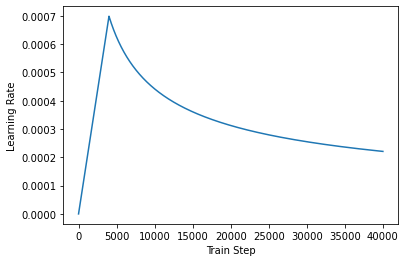

In [46]:
temp_learning_rate_schedule = CustomSchedule(config.d_model)
import matplotlib.pyplot as plt

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [48]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [50]:
checkpoint_path = "/checkpoints/train_nmt_chi_2_eng_bert4"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [51]:
def create_masks(inp, tar):
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

In [52]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [53]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> chinese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 500 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7662 Accuracy 0.0000
Saving checkpoint for epoch 1 at /checkpoints/train_nmt_chi_2_eng_bert4\ckpt-1
Epoch 1 Loss 1.3229 Accuracy 0.0392
Time taken for 1 epoch: 89.96858668327332 secs

Epoch 2 Batch 0 Loss 0.9788 Accuracy 0.0621
Saving checkpoint for epoch 2 at /checkpoints/train_nmt_chi_2_eng_bert4\ckpt-2
Epoch 2 Loss 0.8721 Accuracy 0.0718
Time taken for 1 epoch: 64.38018250465393 secs

Epoch 3 Batch 0 Loss 0.7573 Accuracy 0.0777
Saving checkpoint for epoch 3 at /checkpoints/train_nmt_chi_2_eng_bert4\ckpt-3
Epoch 3 Loss 0.7218 Accuracy 0.0855
Time taken for 1 epoch: 64.26207828521729 secs

Epoch 4 Batch 0 Loss 0.6329 Accuracy 0.0958
Saving checkpoint for epoch 4 at /checkpoints/train_nmt_chi_2_eng_bert4\ckpt-4
Epoch 4 Loss 0.6245 Accuracy 0.0949
Time taken for 1 epoch: 64.55040264129639 secs

Epoch 5 Batch 0 Loss 0.5696 Accuracy 0.1018
Saving checkpoint for epoch 5 at /checkpoints/train_nmt_chi_2_eng_bert4\ckpt-5
Epoch 5 Loss 0.5444 Accuracy 0.1040
Time taken fo

# Evaluate

In [54]:
def encode_en(en):
    tokens_en = tokenizer_chi.tokenize(en)
    lang1 = tokenizer_chi.convert_tokens_to_ids(['[CLS]'] + tokens_en + ['[SEP]'])
    return lang1

In [55]:
def evaluate(transformer, inp_sentence):
    # normalize input sentence
    inp_sentence = encode_en(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_SEQ_LENGTH):
        combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_en.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [56]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  test_tokens = tokenizer_chi.tokenize(sentence)
  sentence = tokenizer_chi.convert_tokens_to_ids(test_tokens)

#   sentence = tokenizer_ques.tokenize(sentence) #.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_chi.convert_ids_to_tokens([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_chi.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [57]:
def translate(transformer, sentence, plot=''):
    result, attention_weights = evaluate(transformer, sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result
                                              if i < tokenizer_en.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted Translation: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
    
    return predicted_sentence

In [58]:
translate(transformer, '你好嗎？')

Input: 你好嗎？
Predicted Translation: have you good done ?


'have you good done ?'

In [59]:
translate(transformer, '你要去哪裡？')

Input: 你要去哪裡？
Predicted Translation: where are you going to go ?


'where are you going to go ?'

In [60]:
translate(transformer, '很高興認識你')

Input: 很高興認識你
Predicted Translation: mary knew mary s happy .


'mary knew mary s happy .'

# Save Weights

In [61]:
transformer.save_weights('/weights/nmt_chi_2_en_bert_ckpt')

In [62]:
new_transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
fn_out, _ = new_transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
new_transformer.load_weights('/weights/nmt_chi_2_en_bert_ckpt')

In [63]:
translate(new_transformer, '我飽了')

Input: 我飽了
Predicted Translation: i m wrong .


'i m wrong .'

In [65]:
# del en_val[36]
# del chi_val[36]
# del en_val[123]
# del chi_val[123]

In [66]:
len(en_val)

998

In [67]:
bleuplus = 0
i = 0

for chi_, en_ in zip(chi_val[0:497],en_val[0:497]):
    print(i)
    predicted = translate(new_transformer, chi_)
    print('Real Translation: {}'.format(en_))
    bleu_ = bleu.sentence_bleu([en_.split()], predicted.split())
    print("BLEU Score: ", bleu_)
    print("----" *20)

    bleuplus += bleu_
    i += 1

0
Input: 如果你有一万美元，你想做什么呢？
Predicted Translation: what do you want to be with , do  ?
Real Translation: what would you do if you had ten thousand dollars ?
BLEU Score:  1.3109733799909448e-231
--------------------------------------------------------------------------------
1


C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

Input: 每次听到这首歌，都会让我回忆起自己年轻的时候。
Predicted Translation: let s do your long time and i can t gomet .
Real Translation: when i hear that song , i remember my younger days .
BLEU Score:  1.1640469867513693e-231
--------------------------------------------------------------------------------
2
Input: 你上一次用Facebook是什麼時候？
Predicted Translation: when are you from a little time ?
Real Translation: when was the last time you spent time on facebook ?
BLEU Score:  1.052907923529733e-231
--------------------------------------------------------------------------------
3
Input: 你记事情的能力并不比我好多少。
Predicted Translation: i am much better than i could be better than many o same years .
Real Translation: you are no better at remembering things than i am .
BLEU Score:  6.968148412761692e-155
--------------------------------------------------------------------------------
4
Input: 你似乎并不像汤姆看起来那样害怕
Predicted Translation: he seems to be as if tom were as sister .
Real Translation: you don t seem to be as afraid a

Input: 大象是如今现存的陆生动物里最大的。
Predicted Translation: monday she is now very now very now now now now now now now now now now now now now now now now now now now now now now now now now now now now now now now now now 
Real Translation: elephants are the largest land animals alive today .
BLEU Score:  0
--------------------------------------------------------------------------------
31
Input: 屋裡的每個人都被發生的事驚住了。
Predicted Translation: everybody was surprised to do that .
Real Translation: everybody in the room was stunned by what happened .
BLEU Score:  9.602579706020654e-232
--------------------------------------------------------------------------------
32
Input: 除了汤姆以外任何人都知道他没必要这么做。
Predicted Translation: we didn t know why he did .
Real Translation: everyone except tom knew he didn t need to do that .
BLEU Score:  4.677275655524805e-155
--------------------------------------------------------------------------------
33
Input: 每個人都應該做自己命運的主人。
Predicted Translation: everyone should be bicycle

Input: 我想去換我昨天買的這件襯衫。
Predicted Translation: i d like to discuss the letter yesterday .
Real Translation: i d like to exchange this shirt i bought yesterday .
BLEU Score:  0.2842202242491899
--------------------------------------------------------------------------------
60
Input: 除非他们事先修好刹车，我才会买车子。
Predicted Translation: i can do a train if i do you do your car .
Real Translation: i ll only buy the car if they fix the brakes first .
BLEU Score:  1.3568676344828118e-231
--------------------------------------------------------------------------------
61
Input: 我很失望我沒能和她一起去。
Predicted Translation: i can t stay with her from expect her husband with her husband with her husband with her husband with her husband with her husband with her husband with her husband with her husband with her husband with her husband 
Real Translation: i m disappointed that i wasn t able to go with her .
BLEU Score:  3.3566500347661918e-155
------------------------------------------------------------------------

Input: 林肯總統就是我們所謂白手起家的男人。
Predicted Translation: i wish i had a gift before i were hat .
Real Translation: president lincoln was what we call a self made man .
BLEU Score:  1.1896457329133973e-231
--------------------------------------------------------------------------------
89
Input: 有關癌症成因的研究耗費頗巨。
Predicted Translation: there is been as many brown th .
Real Translation: research on the causes of cancer is very expensive .
BLEU Score:  1.0032743411283238e-231
--------------------------------------------------------------------------------
90
Input: 她唱歌唱得比班上任何一個人好。
Predicted Translation: she sang better better better better than a good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good 
Real Translation: she can sing better than anybody else in her class .
BLEU Score:  3.1237148326586e-155
--------------------------------------------------------------------------------
91
Input: 她锻

Input: 这家公司在巴黎证券交易所上市了。
Predicted Translation: as large cost he will be cross for many arrive in the park .
Real Translation: this company is listed on the paris stock exchange .
BLEU Score:  1.1200407237786664e-231
--------------------------------------------------------------------------------
116
Input: 这本导游册子或许会对你的旅行有帮助。
Predicted Translation: i did not many english need to help food .
Real Translation: this guidebook might be of use to you on your trip .
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
117
Input: 据我所知，这个谣言不是真的。
Predicted Translation: i found the best i really really really really really really really really really really really really really really really really really really really really really really really really really really really really really really really really really really really 
Real Translation: to the best of my knowledge , the rumor is not true .
BLEU Score:  2.8225949814960253e-1

Input: 我不想成為整天泡在沙發上看電視的人。
Predicted Translation: i want to be some apple .
Real Translation: a couch potato is something that i don t want to be .
BLEU Score:  2.421189997705526e-78
--------------------------------------------------------------------------------
145
Input: 喝醉的驾驶员对车祸有责任。
Predicted Translation: he can t be a lot of mary will be many bad thirty .
Real Translation: a drunk driver was responsible for the car accident .
BLEU Score:  1.1200407237786664e-231
--------------------------------------------------------------------------------
146
Input: 火警發生在他們住的旅館。
Predicted Translation: the fire happened his way in the fire was ended .
Real Translation: a fire broke out at the inn where they were staying .
BLEU Score:  1.2021513525930774e-231
--------------------------------------------------------------------------------
147
Input: 突然之間，三隻狗出現在我們面前。
Predicted Translation: we re now time in boston .
Real Translation: all of a sudden , three dogs appeared in front of us .
BLEU Scor

Input: 你認為野餐要多長時間？
Predicted Translation: how long would you like a long time ?
Real Translation: how long did you think the picnic was going to last ?
BLEU Score:  5.189066807518457e-155
--------------------------------------------------------------------------------
175
Input: 由于噪音，我无法集中精力工作了。
Predicted Translation: we didn t get to the job . i have to job .
Real Translation: i can t concentrate on my work because of the noise .
BLEU Score:  1.3568676344828118e-231
--------------------------------------------------------------------------------
176
Input: 我无法取代她做英语老师。
Predicted Translation: i can t speak and her teacher .
Real Translation: i can t take the place of her as an english teacher .
BLEU Score:  3.145106553777204e-78
--------------------------------------------------------------------------------
177
Input: 我打算在澳大利亚过新年。
Predicted Translation: i ve never been to many years .
Real Translation: i plan to spend the new year s holiday in australia .
BLEU Score:  8.64706850344233

Input: 我爸爸已经戒烟戒酒了。
Predicted Translation: my father runs in drinking .
Real Translation: my father has already given up smoking and drinking .
BLEU Score:  5.5034464391059774e-155
--------------------------------------------------------------------------------
202
Input: 我的手抖得太厉害，没法穿针了。
Predicted Translation: my lives in my high a single little minutes .
Real Translation: my hands were shaking too much to thread the needle .
BLEU Score:  1.1023928157275093e-231
--------------------------------------------------------------------------------
203
Input: 他們沒有人了解她暗示什麼。
Predicted Translation: even books didn t see him any longer .
Real Translation: none of them could understand what she was implying .
BLEU Score:  9.412234823955334e-232
--------------------------------------------------------------------------------
204
Input: 我們都不認為他是事故的罪魁禍首。
Predicted Translation: we all his always are all never both both both both both both both both both both both both both both both both both both both

Input: 风刮得太猛，他们没法在公园里玩了。
Predicted Translation: i can t be in a bus can t be last to you .
Real Translation: the wind blew too hard for them to play in the park .
BLEU Score:  1.2395288183339461e-231
--------------------------------------------------------------------------------
231
Input: 河對岸有很多的垃圾。
Predicted Translation: there was a lot of city in the large project ?
Real Translation: there s a lot of trash on the far bank of the river .
BLEU Score:  2.9477005304904675e-78
--------------------------------------------------------------------------------
232
Input: 他們對他們的員工保證就業。
Predicted Translation: they can be out of his work .
Real Translation: they guaranteed regular employment to their workers .
BLEU Score:  1.2882297539194154e-231
--------------------------------------------------------------------------------
233
Input: 這是三十年代以來最乾旱的六月。
Predicted Translation: it was six th , i studied last year .
Real Translation: this has been the driest six months in thirty years .
BLEU Score

Input: 全世界許多國家的人說英語。
Predicted Translation: world is spoken in many countries .
Real Translation: english is spoken in many countries around the world .
BLEU Score:  0.43564355400687105
--------------------------------------------------------------------------------
260
Input: 除了汤姆以外任何人都知道他没必要这么做。
Predicted Translation: we didn t know why he did .
Real Translation: everyone but tom knew that he didn t need to do that .
BLEU Score:  4.127681278534973e-155
--------------------------------------------------------------------------------
261
Input: 觉得渴了就喝点。
Predicted Translation: tom was a french worker .
Real Translation: feel free to get yourself a drink if you are thirsty .
BLEU Score:  5.092529201164552e-232
--------------------------------------------------------------------------------
262
Input: 新鮮水果和蔬菜有益健康。
Predicted Translation: many americans likes to eat more than possible .
Real Translation: fresh fruits and vegetables are good for your health .
BLEU Score:  9.412234823955334e-

Input: 在我看來，她有一種誇張的傾向。
Predicted Translation: she looks something we see her see her see her see her see her see her see her see her see her see her see her see her see her see her see her see her see her see her 
Real Translation: it seems to me that she has a tendency to exaggerate .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
289
Input: 安靜到連針掉在地上的聲音你都會聽得到。
Predicted Translation: come back and see a lot of fun .
Real Translation: it was so still that you would have heard a pin drop .
BLEU Score:  8.020204191025903e-232
--------------------------------------------------------------------------------
290
Input: 让我像这样继续下去是绝对不可能的。
Predicted Translation: it s impossible to get to get to get to get to get out me to be a pity of cold .
Real Translation: it s absolutely impossible for me to go on like this .
BLEU Score:  5.9883480390466785e-155
----------------------------------------------------------------------------

Input: 王子愛上了一個樵夫的女兒。
Predicted Translation: do you love as much as a day .
Real Translation: the prince fell in love with a woodcutter s daughter .
BLEU Score:  1.1084551487393798e-231
--------------------------------------------------------------------------------
317
Input: 这位老师用试验论证了这个想法。
Predicted Translation: many people move the work to the job .
Real Translation: the teacher demonstrated the idea with an experiment .
BLEU Score:  1.384292958842266e-231
--------------------------------------------------------------------------------
318
Input: 老师按照身高给孩子们排队。
Predicted Translation: it s too nice to getting by people .
Real Translation: the teacher lined the children up in order of height .
BLEU Score:  8.422437779564611e-232
--------------------------------------------------------------------------------
319
Input: 在德國北部有很多美麗的城堡？
Predicted Translation: many famous famous famous famous shouldn t be many famous america ?
Real Translation: there are many beautiful castles in northern 

Input: 除非你想去, 否則你不必去這個派對。
Predicted Translation: you want to go to the find to go to attend to attend to attend to attend to attend to the party .
Real Translation: you don t have to go to the party unless you want to .
BLEU Score:  0.178551492991616
--------------------------------------------------------------------------------
346
Input: 你看起來很累。你應該休息一兩個小時。
Predicted Translation: he looks a lot of time will two hours .
Real Translation: you look tired . you ought to rest for an hour or two .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
347
Input: 你應該偶爾照顧孩子。
Predicted Translation: you ought to clean the children .
Real Translation: you should look after the children from time to time .
BLEU Score:  4.948050447709567e-155
--------------------------------------------------------------------------------
348
Input: 你是那個建議我們一起旅行的人。
Predicted Translation: it s not we didn t like we last we work .
Real Translation: you r

Input: 我认为我现在有足够的钱买我想要的那辆车。
Predicted Translation: i think i think i wanted to have a friend of now .
Real Translation: i think i now have enough money to buy the car i want .
BLEU Score:  3.5142246021315553e-78
--------------------------------------------------------------------------------
375
Input: 我把他带到校区里最贵的餐馆去了。
Predicted Translation: i threw the tell what she is hotel room .
Real Translation: i took him to the most expensive restaurant on campus .
BLEU Score:  1.2199981975731961e-231
--------------------------------------------------------------------------------
376
Input: 我遇上了陣雨被淋得全身濕透。
Predicted Translation: i got to cross the rain .
Real Translation: i was caught in a shower and got drenched to the skin .
BLEU Score:  7.107615103904954e-232
--------------------------------------------------------------------------------
377
Input: 我在機場被海關人員搜查。
Predicted Translation: tom was studying by his class .
Real Translation: i was searched by the customs officers at the airport .
BLE

Input: 有时候，我们应该后退一步想一想。
Predicted Translation: i can t tell me when to do .
Real Translation: once in a while , we should take a step back and think .
BLEU Score:  6.034940380417626e-232
--------------------------------------------------------------------------------
403
Input: 哲学不是我们用六个月就能学的东西。
Predicted Translation: guess we were knew where we used to .
Real Translation: philosophy is not a thing one can learn in six months .
BLEU Score:  7.536728468577135e-232
--------------------------------------------------------------------------------
404
Input: 请来两杯茶和一杯咖啡。
Predicted Translation: would you like tea and a coffee , coffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffee
Real Translation: please bring us two cups of tea and one cup of coffee .
BLEU Score:  4.321152918418559e-155
--------------------------------------------------------------------

Input: 湯姆大概不知道為什麼野餐取消了。
Predicted Translation: tom doesn t know why .
Real Translation: tom probably doesn t know why the picnic was canceled .
BLEU Score:  0.24439253249722204
--------------------------------------------------------------------------------
430
Input: 汤姆说玛丽可能还在学法语
Predicted Translation: tom said mary mary mary to study french .
Real Translation: tom said that mary was probably still studying french .
BLEU Score:  8.148621569148421e-155
--------------------------------------------------------------------------------
431
Input: 汤姆告诉玛丽他不能做她要他做的事。
Predicted Translation: tom will tell mary why mary had to do this .
Real Translation: tom told mary he couldn t do what she asked him to do .
BLEU Score:  5.2435159800408115e-155
--------------------------------------------------------------------------------
432
Input: 因為一份獎學金，Tom得以上大學。
Predicted Translation: he was too student and he was school .
Real Translation: tom was able to go to college thanks to a scholarship .
BLEU Sco

Input: 你记得自己该买蜡烛吗？
Predicted Translation: do you remember to take by baseball ?
Real Translation: did you remember that you were supposed to buy candles ?
BLEU Score:  5.300047673625059e-155
--------------------------------------------------------------------------------
459
Input: 你想我们先结婚还是先生孩子？
Predicted Translation: when didn t children an children an children , tom ?
Real Translation: do you want to get married first or have a child first ?
BLEU Score:  8.34060433022243e-232
--------------------------------------------------------------------------------
460
Input: 說英語的時候不要怕犯錯。
Predicted Translation: don t be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid to be afraid 
Real Translation: don t be afraid to make mistakes when speaking english .
BLEU Score:  0.08600383785890306
--------------------------------------------------------------------------------
461
Input: 當你說英語的時候不要怕犯錯。


Input: 我决定去美国，而不是欧洲。
Predicted Translation: i m not to know a one .
Real Translation: instead of going to europe , i decided to go to america .
BLEU Score:  7.631011170724675e-232
--------------------------------------------------------------------------------
487
Input: 先熨烫领子的里面，然后是外面。
Predicted Translation: help , which is he .
Real Translation: iron the inside of collars first , and then the outside .
BLEU Score:  5.092529201164552e-232
--------------------------------------------------------------------------------
488
Input: 海王星繞行太陽一周要花一百六十五年。
Predicted Translation: hokkaido is going to boston .
Real Translation: it takes years for neptune to orbit around the sun .
BLEU Score:  6.016112399618114e-232
--------------------------------------------------------------------------------
489
Input: 那是在我到家以后，我才不见了我的钱包。
Predicted Translation: that s the truth , i went me or guy one .
Real Translation: it was not until i reached home that i missed my purse .
BLEU Score:  1.1852285898528657e-

In [68]:
en_val[497]

'lake baikal in russia is the deepest lake in the world .'

In [69]:
predicted = translate(new_transformer, chi_val[497])
print('Real Translation: {}'.format(en_))
bleu_ = bleu.sentence_bleu([en_val[497].split()], predicted.split())
print("BLEU Score: ", bleu_)

Input: 俄羅斯的貝加爾湖是世界上最深的湖泊。
Predicted Translation: if new watching watching begin in a major lake .
Real Translation: lake baikal in russia is the deepest lake in the world .
BLEU Score:  1.1039000191006554e-231


C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

In [70]:
bleuplus += bleu_

In [71]:
bleuplus/498

0.0050708621164006935